<a href="https://colab.research.google.com/github/rahvlrawat/CassavaLeafDiseaseClassification/blob/main/Cassava_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installations/Declarations

In [ ]:
import os
import datetime
import copy
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tqdm import tqdm_notebook as tq
import psutil

In [ ]:
# os.system('!pip install --upgrade --force-reinstall --no-deps kaggle')
# os.system('mkdir ~/.kaggle')
# os.system('cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/')
# os.system('chmod 600 ~/.kaggle/kaggle.json')
# !kaggle competitions download -c 'cassava-leaf-disease-classification'
# !unzip /content/cassava-leaf-disease-classification.zip
# !mv Cassava/  /content/drive/MyDrive/

In [ ]:
from pathlib import Path

In [ ]:
BASE_PATH= Path('/content/drive/MyDrive/Cassava/')

#Preprocessing Data+ EDA


In [ ]:
os.listdir(BASE_PATH)

['label_num_to_disease_map.json',
 'train.csv',
 'test_images',
 'train_images',
 '.ipynb_checkpoints',
 'sample_submission.csv',
 'cassava_models']

In [ ]:
map_classes=pd.read_json(BASE_PATH/'label_num_to_disease_map.json',typ='series')

In [ ]:
map_classes

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

In [ ]:
image_paths= os.listdir(BASE_PATH/'train_images')
print(f"Number of train images: {len(image_paths)}")

OSError: ignored

In [ ]:
image_shapes = {}
for image_name in image_paths[:300]:
    image = cv2.imread(os.path.join(BASE_PATH/"train_images"/image_name))
    image_shapes[image.shape] = image_shapes.get(image.shape, 0) + 1
print(image_shapes)

In [ ]:
df_train = pd.read_csv(BASE_PATH/"train.csv")
df_train["class_name"] = df_train["label"].map(map_classes)
df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

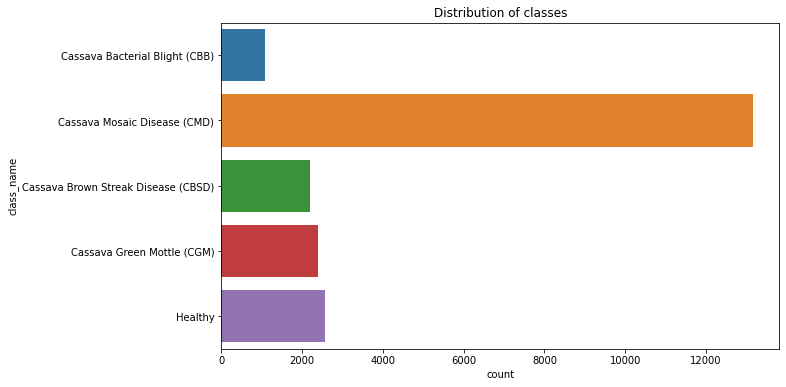

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Distribution of classes')
sns.countplot(y="class_name", data=df_train)

In [ ]:
def view_images(image_ids, labels):
    plt.figure(figsize=(20, 20))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(BASE_PATH/"train_images"/image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"Class: {label},name: {image_id}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df_train.sample(9)
image_ids = tmp_df["image_id"].values
labels = tmp_df["class_name"].values
view_images(image_ids, labels)

#Train

In [ ]:
import torch
import torch.nn as nn 
import torchvision
from PIL import Image
from sklearn import metrics,model_selection

In [ ]:
import torchvision.transforms as transforms

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
df_train= df_train.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train.head()

image_id  label                    class_name
0  3813040999.jpg      3  Cassava Mosaic Disease (CMD)
1   514376645.jpg      3  Cassava Mosaic Disease (CMD)
2  2928426348.jpg      2    Cassava Green Mottle (CGM)
3  2730840788.jpg      3  Cassava Mosaic Disease (CMD)
4  2405303005.jpg      3  Cassava Mosaic Disease (CMD)

In [ ]:
# dfx_train,dfx_valid=model_selection.train_test_split(
#     df_train,
#     test_size=0.2,
#     random_state=42,
# )


In [ ]:
# dfx_train

image_id  label                           class_name
14618   827007782.jpg      2           Cassava Green Mottle (CGM)
13344  2479205385.jpg      4                              Healthy
11327  1454944435.jpg      3         Cassava Mosaic Disease (CMD)
8757   3605605369.jpg      3         Cassava Mosaic Disease (CMD)
4696   2790112645.jpg      2           Cassava Green Mottle (CGM)
...               ...    ...                                  ...
11284  3930711994.jpg      1  Cassava Brown Streak Disease (CBSD)
11964  3513806994.jpg      3         Cassava Mosaic Disease (CMD)
5390    469651575.jpg      3         Cassava Mosaic Disease (CMD)
860     385046246.jpg      4                              Healthy
15795  2491179665.jpg      3         Cassava Mosaic Disease (CMD)

[17117 rows x 3 columns]

In [ ]:
# df_train= df_train.reset_index(drop=True)
# df_valid= df_valid.reset_index(drop=True)


In [ ]:
# df_train.shape,df_valid.shape

((17117, 4), (4280, 4))

In [ ]:
# image_path=BASE_PATH/'train_images'
# train_image_paths=[
#                    os.path.join(image_path,x) for x in df_train.image_id.values
# ]
# valid_image_paths=[
#                    os.path.join(image_path,x) for x in df_valid.image_id.values
# ]

In [ ]:
# train_targets=df_train.label.values
# valid_targets=df_valid.label.values

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,image_paths, targets,augmentations=None):
      self.image_paths = image_paths
      self.targets = targets
      self.augmentations = augmentations
    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self, index):
      targets= self.targets[index]
      image = Image.open(self.image_paths[index])
      image = np.array(image)
      if self.augmentations is not None:
        augmented = self.augmentations(image=image)
        image = augmented["image"]
        
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return{
          "image": torch.tensor(image),
          "targets": torch.tensor(targets)
          }

In [ ]:
# train_dataset=ImageDataset(
#     image_paths=train_image_paths,
#     targets=train_targets,
#     augmentations=None
# )

In [ ]:
train_dataset[0]

{'image': tensor([[[156., 147., 166.,  ...,  64.,  66.,  66.],
          [212., 182., 174.,  ...,  59.,  64.,  69.],
          [224., 173., 145.,  ...,  59.,  70.,  80.],
          ...,
          [123., 111.,  97.,  ...,   8.,   6.,   6.],
          [137., 123., 109.,  ...,   6.,   5.,   5.],
          [140., 131., 123.,  ...,   5.,   6.,   6.]],
 
         [[104.,  94., 113.,  ...,  42.,  44.,  44.],
          [159., 129., 121.,  ...,  37.,  42.,  47.],
          [171., 120.,  92.,  ...,  37.,  48.,  59.],
          ...,
          [139., 130., 121.,  ...,   0.,   0.,   0.],
          [143., 133., 126.,  ...,   0.,   1.,   1.],
          [138., 133., 134.,  ...,   1.,   2.,   2.]],
 
         [[108., 100., 123.,  ...,  44.,  46.,  46.],
          [165., 137., 131.,  ...,  39.,  44.,  49.],
          [177., 128., 102.,  ...,  39.,  50.,  58.],
          ...,
          [110.,  98.,  87.,  ...,   0.,   0.,   0.],
          [117., 106.,  94.,  ...,   0.,   0.,   0.],
          [115., 109.,

In [ ]:
# def plot_image(image_dict):
#   image_tensor=image_dict["image"]
#   target=image_dict["targets"]
#   print(target)
#   plt.figure(figsize=(5,5))
#   image=image_tensor.permute(1,2,0)/255
#   plt.imshow(image)

In [ ]:
plot_image(train_dataset[9])

In [ ]:
import albumentations

In [ ]:
train_aug=albumentations.Compose(
        [
          albumentations.RandomSizedCrop(min_max_height=(224,224),height=224, width=224, p=0.5),
          albumentations.RandomRotate90(p=0.5),
          albumentations.VerticalFlip(p=0.5),
          albumentations.HorizontalFlip(p=0.5),
          albumentations.Cutout(p=0.5),
          albumentations.RandomBrightnessContrast(
              brightness_limit=(-0.1,0.1), 
              contrast_limit=(-0.1, 0.1), 
              p=0.5
              ),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406], 
              std=[0.229, 0.224, 0.225], 
              max_pixel_value=255.0, 
              p=1.0
              ),
         
          albumentations.Resize(height=224, width=224, p=1.0)
        
        ],
        p=1.0,     
    )

In [ ]:
valid_aug = albumentations.Compose(
        [
          albumentations.Resize(height=224, width=224, p=1.0),
          albumentations.RandomBrightnessContrast(
              brightness_limit=(-0.1,0.1), 
              contrast_limit=(-0.1, 0.1), 
              p=0.5
              ),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406], 
              std=[0.229, 0.224, 0.225], 
              max_pixel_value=255.0, 
              p=1.0
              )
        ],
        p=1.0,
    )

In [ ]:
# train_dataset=ImageDataset(
#     image_paths=train_image_paths,
#     targets=train_targets,
#     augmentations=train_aug
# )
# valid_dataset=ImageDataset(
#     image_paths=valid_image_paths,
#     targets=valid_targets,
#     augmentations=valid_aug
# )

In [ ]:
# plot_image(valid_dataset[88])

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from enum import Enum
class ModelState(Enum):
    TRAIN = "train"
    VALID = "valid"
    TEST = "test"
    END = "end"


class TrainingState(Enum):
    TRAIN_START = "on_train_start"
    TRAIN_END = "on_train_end"
    EPOCH_START = "on_epoch_start"
    EPOCH_END = "on_epoch_end"
    TRAIN_EPOCH_START = "on_train_epoch_start"
    TRAIN_EPOCH_END = "on_train_epoch_end"
    VALID_EPOCH_START = "on_valid_epoch_start"
    VALID_EPOCH_END = "on_valid_epoch_end"
    TRAIN_STEP_START = "on_train_step_start"
    TRAIN_STEP_END = "on_train_step_end"
    VALID_STEP_START = "on_valid_step_start"
    VALID_STEP_END = "on_valid_step_end"
    TEST_STEP_START = "on_test_step_start"
    TEST_STEP_END = "on_test_step_end"

In [ ]:
# Code taken from https://github.com/fhopfmueller/bi-tempered-loss-pytorch/blob/master/bi_tempered_loss_pytorch.py

def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()


In [ ]:
#https://github.com/abhishekkrthakur/tez/blob/main/tez/model/model.py
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_loader = None
        self.valid_loader = None
        self.optimizer = None
        self.scheduler = None
        self.step_scheduler_after = None
        self.step_scheduler_metric = None
        self.current_epoch = 0
        self.current_train_step = 0
        self.current_valid_step = 0
        self._model_state = None
        self._train_state = None
        self._callback_runner = None
        self.fp16 = False
        self.scaler = None
        self.metrics = {}
        self.metrics["train"] = {}
        self.metrics["valid"] = {}
        self.metrics["test"] = {}

    @property
    def model_state(self):
        return self._model_state

    @model_state.setter
    def model_state(self, value):
        self._model_state = value
        # run something here in future if needed

    @property
    def train_state(self):
        return self._train_state

    @train_state.setter
    def train_state(self, value):
        self._train_state = value
        if self._callback_runner is not None:
            self._callback_runner(value)

    def _init_model(
        self,
        device,
        train_dataset,
        valid_dataset,
        train_sampler,
        valid_sampler,
        train_bs,
        valid_bs,
        n_jobs,
        callbacks,
        fp16,
    ):

        if callbacks is None:
            callbacks = list()

        if n_jobs == -1:
            n_jobs = psutil.cpu_count()

        if next(self.parameters()).device != device:
            self.to(device)

        if self.train_loader is None:
            self.train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=train_bs,
                num_workers=n_jobs,
                sampler=train_sampler,
                shuffle=True,
            )
        if self.valid_loader is None:
            if valid_dataset is not None:
                self.valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=valid_bs,
                    num_workers=n_jobs,
                    sampler=valid_sampler,
                    shuffle=False,
                )

        if self.optimizer is None:
            self.optimizer = self.fetch_optimizer()

        if self.scheduler is None:
            self.scheduler = self.fetch_scheduler()

        self.fp16 = fp16
        if self.fp16:
            self.scaler = torch.cuda.amp.GradScaler()

        self._callback_runner = CallbackRunner(callbacks, self)
        self.train_state = TrainingState.TRAIN_START

    def monitor_metrics(self, *args, **kwargs):
        return

    def loss(self, *args, **kwargs):
        return

    def fetch_optimizer(self, *args, **kwargs):
        return

    def fetch_scheduler(self, *args, **kwargs):
        return

    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs)

    def train_one_step(self, data, device):
        self.optimizer.zero_grad()
        for key, value in data.items():
            data[key] = value.to(device)
        if self.fp16:
            with torch.cuda.amp.autocast():
                _, loss, metrics = self(**data)
        else:
            _, loss, metrics = self(**data)
        with torch.set_grad_enabled(True):
            if self.fp16:
                with torch.cuda.amp.autocast():
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
            else:
                loss.backward()
                self.optimizer.step()
            if self.scheduler:
                if self.step_scheduler_after == "batch":
                    if self.step_scheduler_metric is None:
                        self.scheduler.step()
                    else:
                        self.scheduler.step(self.step_scheduler_metric)
        return loss, metrics

    def validate_one_step(self, data, device):
        for key, value in data.items():
            data[key] = value.to(device)
        _, loss, metrics = self(**data)
        return loss, metrics

    def predict_one_step(self, data, device):
        for key, value in data.items():
            data[key] = value.to(device)
        output, _, _ = self(**data)
        return output

    def update_metrics(self, losses, monitor):
        self.metrics[self._model_state.value].update(monitor)
        self.metrics[self._model_state.value]["loss"] = losses.avg

    def train_one_epoch(self, data_loader, device):
        self.train()
        self.model_state = ModelState.TRAIN
        losses = AverageMeter()
        tk0 = tq(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            self.train_state =TrainingState.TRAIN_STEP_START
            loss, metrics = self.train_one_step(data, device)
            self.train_state = TrainingState.TRAIN_STEP_END
            losses.update(loss.item(), data_loader.batch_size)
            if b_idx == 0:
                metrics_meter = {k: AverageMeter() for k in metrics}
            monitor = {}
            for m_m in metrics_meter:
                metrics_meter[m_m].update(metrics[m_m], data_loader.batch_size)
                monitor[m_m] = metrics_meter[m_m].avg
            self.current_train_step += 1
            tk0.set_postfix(loss=losses.avg, stage="train", **monitor)
        tk0.close()
        self.update_metrics(losses=losses, monitor=monitor)
        return losses.avg

    def validate_one_epoch(self, data_loader, device):
        self.eval()
        self.model_state = ModelState.VALID
        losses = AverageMeter()
        tk0 = tq(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            self.train_state = TrainingState.VALID_STEP_START
            with torch.no_grad():
                loss, metrics = self.validate_one_step(data, device)
            self.train_state = TrainingState.VALID_STEP_END
            losses.update(loss.item(), data_loader.batch_size)
            if b_idx == 0:
                metrics_meter = {k: AverageMeter() for k in metrics}
            monitor = {}
            for m_m in metrics_meter:
                metrics_meter[m_m].update(metrics[m_m], data_loader.batch_size)
                monitor[m_m] = metrics_meter[m_m].avg
            tk0.set_postfix(loss=losses.avg, stage="valid", **monitor)
            self.current_valid_step += 1
        tk0.close()
        self.update_metrics(losses=losses, monitor=monitor)
        return losses.avg

    def process_output(self, output):
        output = output.cpu().detach().numpy()
        return output

    def predict(self, dataset, device, sampler=None, batch_size=16, n_jobs=1):
        if next(self.parameters()).device != device:
            self.to(device)

        if n_jobs == -1:
            n_jobs = psutil.cpu_count()

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=n_jobs, sampler=sampler
        )
        self.eval()
        final_output = []
        tk0 = tq(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            with torch.no_grad():
                out = self.predict_one_step(data, device)
                out = self.process_output(out)
                yield out
            tk0.set_postfix(stage="test")
        tk0.close()

    def save(self, model_path):
        model_state_dict = self.state_dict()
        if self.optimizer is not None:
            opt_state_dict = self.optimizer.state_dict()
        else:
            opt_state_dict = None
        if self.scheduler is not None:
            sch_state_dict = self.scheduler.state_dict()
        else:
            sch_state_dict = None
        model_dict = {}
        model_dict["state_dict"] = model_state_dict
        model_dict["optimizer"] = opt_state_dict
        model_dict["scheduler"] = sch_state_dict
        model_dict["epoch"] = self.current_epoch
        model_dict["fp16"] = self.fp16
        torch.save(model_dict, model_path)

    def load(self, model_path, device="cuda"):
        if next(self.parameters()).device != device:
            self.to(device)
        model_dict = torch.load(model_path)
        self.load_state_dict(model_dict["state_dict"])

    def fit(
        self,
        train_dataset,
        valid_dataset=None,
        train_sampler=None,
        valid_sampler=None,
        device="cuda",
        epochs=10,
        train_bs=16,
        valid_bs=16,
        n_jobs=8,
        callbacks=None,
        fp16=False,
    ):
        self._init_model(
            device=device,
            train_dataset=train_dataset,
            valid_dataset=valid_dataset,
            train_sampler=train_sampler,
            valid_sampler=valid_sampler,
            train_bs=train_bs,
            valid_bs=valid_bs,
            n_jobs=n_jobs,
            callbacks=callbacks,
            fp16=fp16,
        )

        for _ in range(epochs):
            self.train_state =TrainingState.EPOCH_START
            self.train_state =TrainingState.TRAIN_EPOCH_START
            train_loss = self.train_one_epoch(self.train_loader, device)
            self.train_state = TrainingState.TRAIN_EPOCH_END
            if self.valid_loader:
                self.train_state =TrainingState.VALID_EPOCH_START
                valid_loss = self.validate_one_epoch(self.valid_loader, device)
                self.train_state = TrainingState.VALID_EPOCH_END
            if self.scheduler:
                if self.step_scheduler_after == "epoch":
                    if self.step_scheduler_metric is None:
                        self.scheduler.step()
                    else:
                        self.scheduler.step(self.step_scheduler_metric)
            self.train_state =TrainingState.EPOCH_END
            if self._model_state.value == "end":
                break
            self.current_epoch += 1
        self.train_state =TrainingState.TRAIN_END

In [ ]:
from typing import List, Tuple


class Callback:
    def on_epoch_start(self, model, **kwargs):
        return

    def on_epoch_end(self, model, **kwargs):
        return

    def on_train_epoch_start(self, model, **kwargs):
        return

    def on_train_epoch_end(self, model, **kwargs):
        return

    def on_valid_epoch_start(self, model, **kwargs):
        return

    def on_valid_epoch_end(self, model, **kwargs):
        return

    def on_train_step_start(self, model, **kwargs):
        return

    def on_train_step_end(self, model, **kwargs):
        return

    def on_valid_step_start(self, model, **kwargs):
        return

    def on_valid_step_end(self, model, **kwargs):
        return

    def on_test_step_start(self, model, **kwargs):
        return

    def on_test_step_end(self, model, **kwargs):
        return

    def on_train_start(self, model, **kwargs):
        return

    def on_train_end(self, model, **kwargs):
        return


class CallbackRunner:
    def __init__(self, callbacks: List[Callback], model):
        self.model = model
        self.callbacks = callbacks

    def __call__(self, current_state, **kwargs):
        for cb in self.callbacks:
            _ = getattr(cb, current_state.value)(self.model, **kwargs)

In [ ]:
class EarlyStopping(Callback):
    def __init__(self, monitor, model_path, patience=5, mode="min", delta=0.001,epochs=None):
        self.monitor = monitor
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

        if self.monitor.startswith("train_"):
            self.model_state = "train"
            self.monitor_value = self.monitor[len("train_") :]
        elif self.monitor.startswith("valid_"):
            self.model_state = "valid"
            self.monitor_value = self.monitor[len("valid_") :]
        else:
            raise Exception("monitor must start with train_ or valid_")

    def on_epoch_end(self, model):
        epoch_score = model.metrics[self.model_state][self.monitor_value]
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                model.model_state = ModelState.END
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            model.save(self.model_path)
        self.val_score = epoch_score

# Resnet 50

In [ ]:
class Cassava_Resnet(Model):
  def __init__(self,num_classes,pretrained=True):
    super().__init__()
    self.convnet=torchvision.models.resnet50(pretrained=pretrained)
    self.convnet.fc=nn.Linear(2048,num_classes)
    self.step_scheduler_after="epoch"

  
  def loss(self,outputs,targets):
    if targets is None:
      return None 
    return nn.CrossEntropyLoss()(outputs,targets)  

  def monitor_metrics(self,outputs,targets):
    #outputs=torch.argmax(outputs,dim=1).cpu().detach().numpy()
    #targets=targets.cpu().detach().numpy()
    _, preds = torch.max(outputs,1)
    acc=bi_tempered_logistic_loss(outputs,targets, t1=0.8, t2=1.4, label_smoothing=0.2)
    return {
        "bi_tempered_logistic_loss":acc
    }

  def fetch_optimizer(self):
    opt=torch.optim.Adam(self.parameters(),lr=1e-3)
    return opt

  def fetch_scheduler(self):
    sch=torch.optim.lr_scheduler.StepLR(self.optimizer,step_size=0.7)
    return sch

  def forward(self,image,targets=None):
    outputs=self.convnet(image)
    if targets is not None:
      loss=nn.CrossEntropyLoss()(outputs,targets)
      mon_metrics=self.monitor_metrics(outputs,targets)
      return outputs,loss,mon_metrics  
    return outputs,None,None  

In [ ]:
model_resnet=Cassava_Resnet(num_classes=df_train.label.nunique())

In [ ]:
image=train_dataset[0]["image"]
y=train_dataset[0]["targets"]
model_resnet(image.unsqueeze(0))

(tensor([[ 0.2225,  0.0426, -0.1483, -0.3382,  0.3420]],
        grad_fn=<AddmmBackward>), None, None)

In [ ]:
es=EarlyStopping(
    monitor="valid_bi_tempered_logistic_loss",
    model_path="/content/drive/MyDrive/Cassava Models/resmodel.bin",
    patience=5,
    mode="min"
    )

In [ ]:
model_resnet.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=32,
    valid_bs=64,
    device="cuda",
    callbacks=[es],
    fp16=True,
    epochs=50
)

# EfficientNet 

In [ ]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=51a146a2bd8db8856cc96d124f83a144b635c336837634113c43ba2fa2292df0
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet


In [ ]:
class Cassava_Efficientnet(Model):
  def __init__(self,num_classes,pretrained=True):
    super().__init__()
    self.convnet= EfficientNet.from_pretrained('efficientnet-b4', num_classes=num_classes)
    self.step_scheduler_after="epoch"

  
  def loss(self,outputs,targets):
    if targets is None:
      return None 
    return nn.CrossEntropyLoss()(outputs,targets)  

  def monitor_metrics(self,outputs,targets):
    outputs=torch.argmax(outputs,dim=1).cpu().detach().numpy()
    targets=targets.cpu().detach().numpy()
    acc=metrics.accuracy_score(targets,outputs)

    return {
        "accuracy":acc

    }

  def fetch_optimizer(self):
    opt=torch.optim.Adam(self.parameters(),lr=1e-3)
    return opt

  def fetch_scheduler(self):
    sch=torch.optim.lr_scheduler.StepLR(self.optimizer,step_size=0.7)
    return sch

  def forward(self,image,targets=None):
    outputs=self.convnet(image)
    if targets is not None:
      loss=self.loss(outputs,targets)
      mon_metrics=self.monitor_metrics(outputs,targets)
      return outputs,loss,mon_metrics  
    return outputs,None,None  

In [ ]:
model_Efficientnet=Cassava_Efficientnet(num_classes=df_train.label.nunique(),pretrained=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [ ]:
# es=EarlyStopping(
#     monitor="valid_accuracy",
#     model_path="/content/drive/MyDrive/Cassava Models/Effmodel.bin",
#     patience=2,
#     mode="max"
#     )
# model_Efficientnet.fit(
#     train_dataset,
#     valid_dataset=valid_dataset,
#     train_bs=32,
#     valid_bs=64,
#     device="cuda",
#     callbacks=[es],
#     fp16=True,
#     epochs=50
# )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Validation score improved (-inf --> 0.7376066098081023). Saving model!



Validation score improved (0.7376066098081023 --> 0.7874800106609808). Saving model!



Validation score improved (0.7874800106609808 --> 0.8328224946695096). Saving model!



Validation score improved (0.8328224946695096 --> 0.8370535714285714). Saving model!



EarlyStopping counter: 1 out of 2



EarlyStopping counter: 2 out of 2


# For Inference and Submission

In [ ]:
df_submit = pd.read_csv("/content/drive/MyDrive/Cassava/sample_submission.csv")

In [ ]:
test_image_paths=[
                   os.path.join(BASE_PATH/"test_images",x) for x in df_submit.image_id.values
]

In [ ]:
test_targets=df_submit.label.values

In [ ]:
test_dataset = ImageDataset(
    image_paths=test_image_paths,
    targets=test_targets,
    augmentations=valid_aug
)

In [ ]:
model_resnet= Cassava_Resnet(num_classes=df_train.label.nunique())

NameError: ignored

In [ ]:
model_resnet.load("/content/drive/MyDrive/Cassava Models/resmodel.bin")

In [ ]:
preds=model_resnet.predict(test_dataset, batch_size=32, n_jobs=-1, device="cuda")

In [ ]:
list(preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[array([[-3.31862   , -2.1288733 ,  1.2859249 , -0.0099846 ,  0.02727628]],
       dtype=float32)]

In [ ]:
preds

<generator object Model.predict at 0x7fdc1003f410>

In [ ]:
# # run inference 5 times
# final_preds = None
# for j in range(5):
#     preds = model.predict(test_dataset, batch_size=32, n_jobs=-1, device="cuda")
#     temp_preds = None
#     for p in preds:
#         if temp_preds is None:
#             temp_preds = p
#         else:
#             temp_preds = np.vstack((temp_preds, p))
#     if final_preds is None:
#         final_preds = temp_preds
#     else:
#         final_preds += temp_preds
# final_preds /= 5

In [ ]:
# final_preds = final_preds.argmax(axis=1)
# dfx.label = final_preds
# dfx.to_csv("submission.csv", index=False)

In [ ]:
model_Efficientnet=Cassava_Efficientnet(num_classes=df_train.label.nunique(),pretrained=True)

Loaded pretrained weights for efficientnet-b7


In [ ]:
model_Efficientnet.load("/content/drive/MyDrive/Cassava Models/Effmodel.bin")

In [ ]:
model_Efficientnet

In [ ]:
preds=model_Efficientnet.predict(test_dataset, batch_size=32, n_jobs=-1, device="cuda")

In [ ]:
preds=list(preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
preds

In [ ]:
def Emb(model1,model2,test_dataset,batch_size=32):
  preds1=model1.predict(test_dataset, batch_size=32, n_jobs=-1, device="cuda")
  preds2=model2.predict(test_dataset, batch_size=32, n_jobs=-1, device="cuda")
  return preds1,preds2

In [ ]:
x,y=Emb(model_Efficientnet,model_resnet,test_dataset,batch_size=32)

In [ ]:
list(y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[array([[-3.3186195 , -2.1288736 ,  1.2859249 , -0.00998444,  0.02727622]],
       dtype=float32)]

##Test inference

In [ ]:
test_files = get_image_files(BASE_PATH+"test_images/")


In [ ]:
test_dl = learn.dls.test_dl(test_files[:500], with_label=True)

In [ ]:
pred_probas,_,pred_classes =learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
pred_probas.shape,pred_classes.shape

(torch.Size([500, 5]), torch.Size([500]))

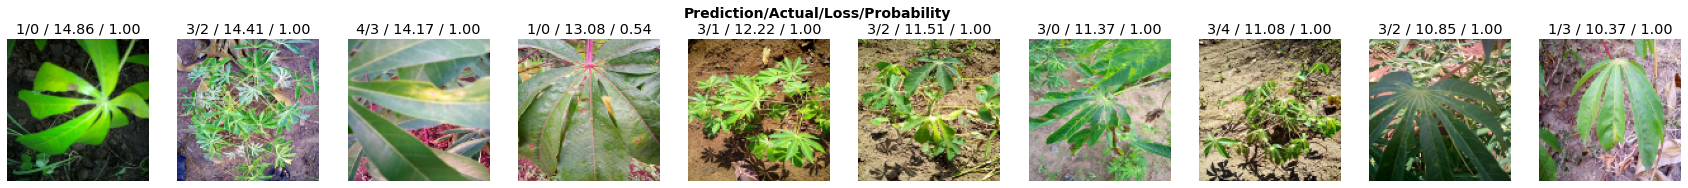

In [ ]:
interp.plot_top_losses(10,nrows=1)

In [ ]:
ImageClassifier(interp)

NameError: ignored

In [ ]:
zz=os.listdir(BASE_PATH+"resized_train_images/")[:500]


In [ ]:
df_train.head()

image_id  label                      class_name  kfold
0   435094576.jpg      0  Cassava Bacterial Blight (CBB)      0
1  2869976219.jpg      3    Cassava Mosaic Disease (CMD)      0
2   808416790.jpg      0  Cassava Bacterial Blight (CBB)      0
3  2479508913.jpg      3    Cassava Mosaic Disease (CMD)      0
4  3567747023.jpg      3    Cassava Mosaic Disease (CMD)      0

In [ ]:
s=[]

In [ ]:
for i in zz:
  s.append(df_train[df_train["image_id"]==zz[0]]["label"].item())

In [ ]:
c=0
for i in range(len(zz)):
  if(s[i]!=pred_classes[i]):
    c+=1
c    


447

In [ ]:
BASE_PATH_TRAIN=BASE_PATH+'train_images/'

In [ ]:
os.sys('mkdir  ')

#Segmentation

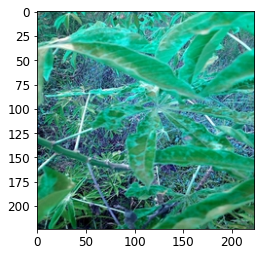

In [ ]:
image = cv2.imread(BASE_PATH+"resized_train_images/"+resizedimagePaths[3263])
plt.imshow(image)

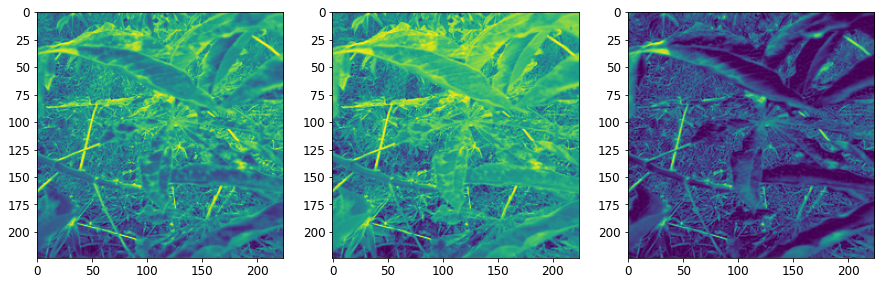

In [ ]:

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# RGB Channel
R = image_rgb[:, :, 0]
G = image_rgb[:, :, 1]
B = image_rgb[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(R)
ax[1].imshow(G)
ax[2].imshow(B)

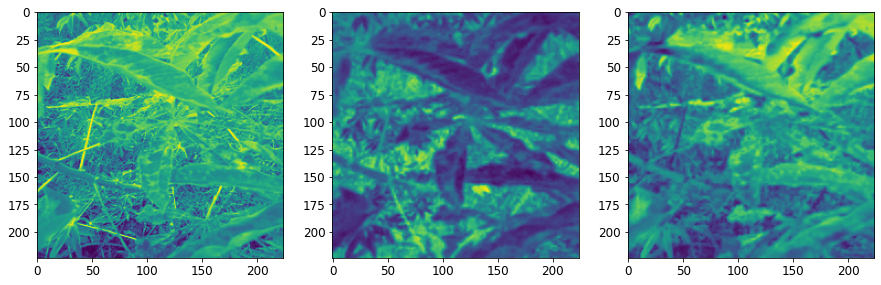

In [ ]:
L = image_lab[:, :, 0]
a = image_lab[:, :, 1]
b = image_lab[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(L)
ax[1].imshow(a)
ax[2].imshow(b)

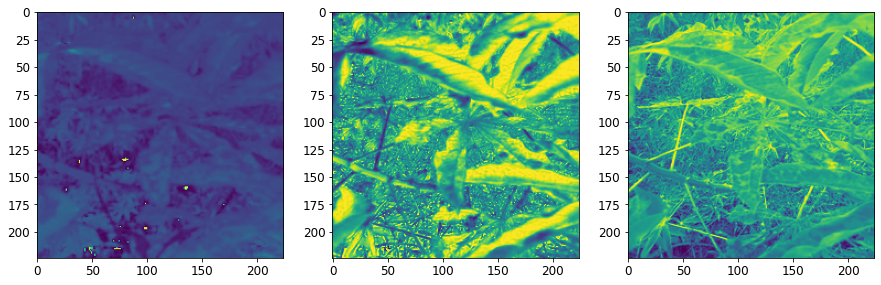

In [ ]:
# HSV Color Space - https://en.wikipedia.org/wiki/HSL_and_HSV
H = image_hsv[:, :, 0]
S = image_hsv[:, :, 1]
V = image_hsv[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(H)
ax[1].imshow(S)
ax[2].imshow(V)

K-means


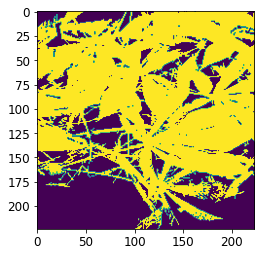

In [ ]:
pixel_vals = g.flatten()
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Since we are interested in only actual leaf pixels, we choose 2 clusters
# one cluster for actual leaf pixels and other for unwanted background pixels.
K = 2
retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((b.shape))
pixel_labels = labels.reshape(image_lab.shape[0], image_lab.shape[1])
# displaying segmented image
plt.imshow(segmented_image)

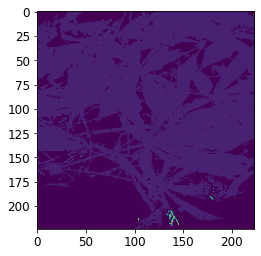

In [ ]:
pixel_labels = np.uint8(pixel_labels)
ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)
plt.imshow(components)

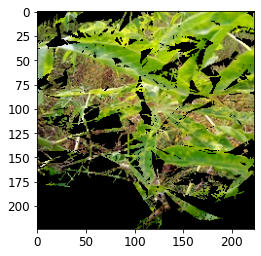

In [ ]:
indices = []
for i in range(1, ret):
    row, col = np.where(components==i)
    indices.append(max(len(row), len(col)))
component = np.argmax(np.array(indices))
main_component = component+1  #indexing starts from 0, so we increment by 1 to get actual component index
# creating a mask and extracting pixels corresponding to cluster to which leaf belongs.
# 1 for actual leaf pixels and 0 for other pixels
mask = np.where(components==main_component, 1, 0)
B = image[:, :, 0]
G = image[:, :, 1]
R = image[:, :, 2]
# Extract only masked pixels
r = R*mask
g = G*mask
b = B*mask
final_image = np.dstack((r, g, b))
plt.imshow(final_image)

# K-fold


In [ ]:
import pandas as pd
from sklearn import model_selection

In [ ]:
image_path=BASE_PATH/'train_images'

In [ ]:
df_train= df_train.sample(frac=1).reset_index(drop=True)
# initiate the kfold class from model_selection module
kf = model_selection.StratifiedKFold(n_splits=5)
# fill the new kfold column
cvscores = []
Fold = 1

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)


In [ ]:
for train,val in kf.split(X=df_train,y=df_train['label']):
  print('Fold:',Fold)
  X_train=df_train.iloc[train,:].reset_index(drop=True)
  X_val=df_train.iloc[val,:].reset_index(drop=True)
  y_train=X_train.label.values
  #y_train=onehot_encoder.fit_transform(y_train.reshape(len(y_train),1))
  y_val=X_val.label.values
  #y_val=onehot_encoder.fit_transform(y_val.reshape(len(y_val),1))
  train_image_paths=[
                   os.path.join(image_path,x) for x in X_train.image_id.values
  ]
  valid_image_paths=[
                   os.path.join(image_path,x) for x in X_val.image_id.values
  ]
  train_dataset=ImageDataset(
    image_paths=train_image_paths,
    targets=y_train,
    augmentations=train_aug
  )
  valid_dataset=ImageDataset(
    image_paths=valid_image_paths,
    targets=y_val,
    augmentations=valid_aug
  )
  train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=32,
                num_workers=psutil.cpu_count(),    #n_jobs,
                sampler=None,
                shuffle=True,
            )

 
  model_resnet.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=32,
    valid_bs=32,
    device="cuda",
    callbacks=[es],
    fp16=True,
    epochs=20
  )
  # model_name = 'Efficientnet_Fold_'+str(Fold)+'.h5'
  # model.save(BASE_PATH/'cassava_models'/'model_name')
  Fold=Fold+1  

Fold: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: ignored

#Exp


In [ ]:
df_train.columns

Index(['image_id', 'label', 'class_name', 'kfold'], dtype='object')

In [ ]:
df_train.class_name.unique()

array(['Cassava Bacterial Blight (CBB)', 'Cassava Mosaic Disease (CMD)', 'Healthy', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)'], dtype=object)

In [ ]:
map_classes

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

In [ ]:
def get_data(idx):
  return df_train[df_train["label"]==idx]
  

In [ ]:
CBB=get_data(0)
CBSD=get_data(1)
CGM=get_data(2)
CMD=get_data(3)
Healthy=get_data(4)

In [ ]:
Healthy

image_id  label class_name  kfold
5      3981645736.jpg      4    Healthy      0
31     2427490439.jpg      4    Healthy      0
33     3741438822.jpg      4    Healthy      0
38     2410206880.jpg      4    Healthy      0
58     2175327103.jpg      4    Healthy      0
...               ...    ...        ...    ...
21373  4153020952.jpg      4    Healthy      9
21374  2643209244.jpg      4    Healthy      9
21380  1954353329.jpg      4    Healthy      9
21388  2852147190.jpg      4    Healthy      9
21393  4168975711.jpg      4    Healthy      9

[2577 rows x 4 columns]

In [ ]:
Healthy=makeimageArray(Healthy["image_id"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Healthy_Arr=Healthy/255.0

In [ ]:
Healthy_Arr.shape

(1087, 3, 224, 224)

# Get Vectors


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [ ]:
# Load the pretrained model
model = models.resnet50(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

In [ ]:
model.eval()

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [ ]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    image = Image.open(BASE_PATH+'resized_train_images/'+i)
    # 2. Create a PyTorch Variable with the transformed image
    t_image =Variable(normalize(to_tensor(image)).unsqueeze(0))

    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(2048)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.squeeze())
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_image)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding


In [ ]:
imageTensor=Tensor()
imageTensorList=[]

In [ ]:
for i in tq(Healthy["image_id"]):
  imageTensorList.append(get_vector(i))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
tensorStack=torch.stack(imageTensorList)

In [ ]:
tensorStack.numpy().shape

(1087, 2048)

In [ ]:
image_id=Healthy["image_id"]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score



In [ ]:
# Clustering
kmeans = KMeans(n_clusters=3,n_jobs=-1, random_state=22)
kmeans.fit(tensorStack.numpy())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [ ]:
groups = {}
for file, cluster in zip(image_ids,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 25")
        start = np.random.randint(0,len(files))
        files = files[start:start+25]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(5,5,index+1);
        image = Image.open(BASE_PATH+'resized_train_images/'+file)
        image = np.array(image)
        plt.imshow(image)
        plt.title(file)
        plt.axis('off')

In [ ]:
kmeans.labels_

array([2, 0, 0, ..., 0, 1, 0], dtype=int32)

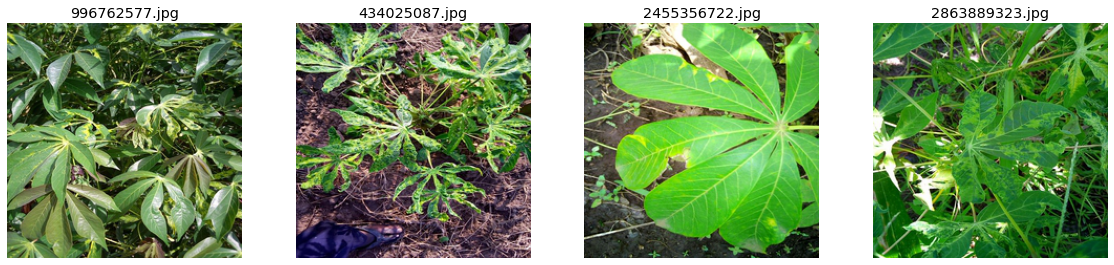

In [ ]:
view_cluster(0)

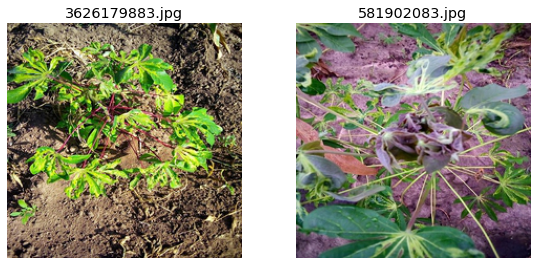

In [ ]:
view_cluster(1)

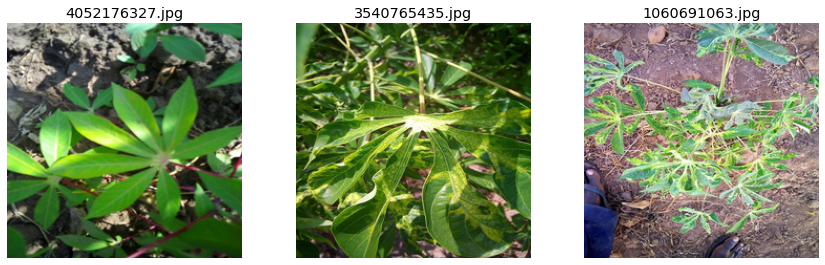

In [ ]:
view_cluster(2)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
# Load the pretrained model
model = models.resnet50(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


# Data Cleaning

In [ ]:
def get_data(idx):
  return df_train[df_train["label"]==idx]

In [ ]:

to_tensor = transforms.ToTensor()

In [ ]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    image = Image.open(BASE_PATH+'resized_train_images/'+image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_image =Variable(to_tensor(image).unsqueeze(0))

    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(2048)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.squeeze())
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_image)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding


In [ ]:
def data_clean(label_no):
  data=get_data(label_no)
  vector_list=[]
  image_distances=[]
  distance=[]
  image_ids=data["image_id"].to_list()
  print(image_ids)
  print("Getting Vectors for Data")
  for i in tq(image_ids):
    vector_list.append(get_vector(i))
  vector_stack=torch.stack(vector_list)
  vector_mean=vector_stack.mean(axis=0)
  # vector_stack_numpy=vector_stack.numpy()
  # vector_mean_numpy=vector_mean.numpy()
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  for i,x in enumerate(vector_stack):
    cos_sim = cos(vector_mean.unsqueeze(0),
              x.unsqueeze(0)).item()
    distance.append(cos_sim)
  image_distances=dict(zip(image_ids,distance))
  return distance,image_distances,data
  




In [ ]:
distance,image_distances,data=data_clean(4)

['1001723730.jpg', '1003442061.jpg', '100560400.jpg', '1009126931.jpg', '1010806468.jpg', '1011571614.jpg', '1011909285.jpg', '1012257169.jpg', '1012902365.jpg', '1014332426.jpg', '1017415426.jpg', '1017827385.jpg', '1019366633.jpg', '1019398233.jpg', '1022932733.jpg', '1023663951.jpg', '1024067372.jpg', '1028128877.jpg', '1033962303.jpg', '1034219276.jpg', '1035014017.jpg', '1039176615.jpg', '1039292236.jpg', '1043086898.jpg', '1043392236.jpg', '1044930186.jpg', '1045099368.jpg', '1045545977.jpg', '10459387.jpg', '1046703257.jpg', '1047154095.jpg', '1047272845.jpg', '1047958369.jpg', '1049791378.jpg', '1050847556.jpg', '105602329.jpg', '105741284.jpg', '1058542448.jpg', '1060543398.jpg', '1060644080.jpg', '1064213029.jpg', '1065833532.jpg', '1067302519.jpg', '1067694987.jpg', '1072588150.jpg', '1073915000.jpg', '1073983503.jpg', '107427326.jpg', '107466550.jpg', '107608677.jpg', '1077647851.jpg', '1077728760.jpg', '107801790.jpg', '1080185160.jpg', '1081937072.jpg', '1082098147.jpg', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
# data=get_data(0)
# vector_list=[]
# image_ids=data["image_id"].to_list()
# print(image_ids)
# for i in tq(image_ids):
#     vector_list.append(get_vector(i))
# vector_stack=torch.stack(vector_list)
# vector_mean=vector_stack.mean(axis=0)
# vector_mean.shape
# cos = nn.CosineSimilarity(dim=1, eps=1e-6)
# distance=[]
# for i,x in enumerate(vector_stack):
#   cos_sim = cos(vector_mean.unsqueeze(0),
#               x.unsqueeze(0)).item()
#   distance.append(cos_sim)
# image_distances=dict(zip(image_ids,distance))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


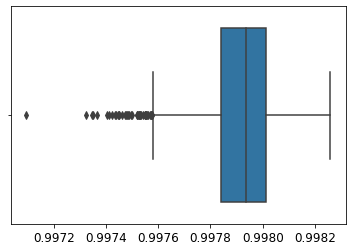

In [ ]:
sns.boxplot(distance)

In [ ]:
len(distance),len(data),len(image_distances)

(2577, 2577, 2577)

In [ ]:
q1 = pd.DataFrame(distance).quantile(0.25)[0]
q3 = pd.DataFrame(distance).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
print(iqr)
print(fence_low)
print(fence_high)
# "Outside" boxplot Reviews
print(distance[(distance < fence_low) | (distance > fence_high)])

0.00017440319061279297
0.9975786209106445
0.9982762336730957


In [ ]:
[distance.index(i) for i in distance if (i< fence_low) | (i> fence_high)]



[79,
 235,
 414,
 416,
 435,
 558,
 596,
 632,
 691,
 710,
 721,
 752,
 829,
 882,
 982,
 984,
 1047,
 1259,
 1369,
 1433,
 1468,
 1478,
 1552,
 1617,
 1644,
 1682,
 1740,
 1928,
 1939,
 1975,
 1987,
 1989,
 2107,
 2194,
 2207,
 2230,
 2389,
 2395,
 2407,
 2555,
 2558,
 2573]

In [ ]:
[i for i in distance if (i< fence_low) | (i> fence_high) ]

In [ ]:
im=data["image_id"].tolist()

In [ ]:
def view_image(ind):
  image = Image.open(BASE_PATH+'resized_train_images/'+im[ind])
  plt.imshow(image)


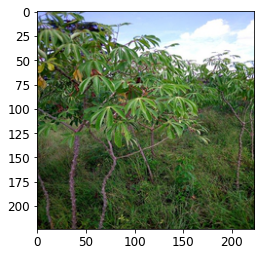

In [ ]:
view_image(2389)